### Корреляционный анализ с помощью Python. Домашнее задание

Чтобы закрепить знания и навыки, полученные во время воркшопа, я предлагаю вам провести корреляционный анализ с помощью Python самостоятельно и исследовать как взаимодействуют между собой вда фактора. В качестве данных для исследования вы будете использовать датасет, собранный `Gapminder Foundation` 

Датасет находится по ссылке:
https://github.com/VasilisaS/product_star_mentoring/blob/main/gapminder.csv

Для работы с данными их  нужно скачать по ссылке выше. Скачивайте обязательно в папку, где лежит Python-ноутбук, с которыми вы будете работать. Таким образом этот файл будет доступен для использования.

Набор данных `Gapminder` содержит набор переменных, используемых для оценки общего 
состояния здоровья и благополучия населения в странах по всему миру. 

##### Импортируем необходимые модули

In [1]:
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi
import scipy
import pandas as pd
from seaborn import regplot
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

##### Исследуем данные, с которыми будем работать 

In [2]:
# загружаем данные 
df = pd.read_csv("gapminder.csv") 
df.head()

,country,incomeperperson,alcconsumption,armedforcesrate,breastcancerper100th,co2emissions,femaleemployrate,hivrate,internetuserate,lifeexpectancy,oilperperson,polityscore,relectricperperson,suicideper100th,employrate,urbanrate
0,Afghanistan,,.03,.5696534,26.8,75944000,25.6000003814697,,3.65412162280064,48.673,,0,,6.68438529968262,55.7000007629394,24.04
1,Albania,1914.99655094922,7.29,1.0247361,57.4,223747333.333333,42.0999984741211,,44.9899469578783,76.918,,9,636.341383366604,7.69932985305786,51.4000015258789,46.72
2,Algeria,2231.99333515006,.69,2.306817,23.5,2932108666.66667,31.7000007629394,.1,12.5000733055148,73.131,.42009452521537,2,590.509814347428,4.8487696647644,50.5,65.22
3,Andorra,21943.3398976022,10.17,,,,,,81,,,,,5.36217880249023,,88.92
4,Angola,1381.00426770244,5.57,1.4613288,23.1,248358000,69.4000015258789,2,9.99995388324075,51.093,,-2,172.999227388199,14.5546770095825,75.6999969482422,56.7


Как мы видим, в данных есть пропущенные значения (это пустая ячейка). 

Для исследования данных с помощью корреляционного анализа необходимо совпадение числа наблюдений для обоих факторов (фактором в данном случае можно назвать любой из столбцов). Обработаем пропущенные значения

In [3]:
# для нескольких факторов проверим, есть ли среди наблюдений пропущенные значения и сколько их

print("Есть ли пропущенные значения? ", df.isnull().values.any())
print()

Есть ли пропущенные значения?  False



Получен интересный результат. Утверждается, что пропусков нет, однако, мы видим, что у нас в столбах довольно много пустых ячеек.

Дело вот в чем ... 
Обыкновенно пропущенное значение характеризуется как None, то есть прото ничего не написано. Однако, именно этот датасет специфичен тем, что на месте пропущенных ячеек стоит пробел ' ', но не None. Из-за этого встроенная функция не смогла дать корректный ответ, когда мы попытались проверить наличие пропусков

In [4]:
# создадим несколько кастомных функций для работы с пропусками 

# функция проверяет пропущенные значения
def check_missing_values(df, cols): 
    for col in cols: 
        print("Column {} is missing:".format(col)) 
        print((df[col].values == ' ').sum()) 
        print() 
        
# функция ковертирует значения в числовые
def convert_numeric(dataframe, cols): 
    for col in cols: 
        dataframe[col] = pd.to_numeric(dataframe[col], 
                                       errors='coerce') 

In [5]:
cols = ['internetuserate', 'employrate']

df2 = df.copy()

convert_numeric(df2, cols)

In [6]:
cols = ['internetuserate', 'employrate']

df2 = df.copy()

check_missing_values(df, cols)

convert_numeric(df2, cols)

Column internetuserate is missing:
21

Column employrate is missing:
35



Как видим, написание кастомной функции позволило корректно находить пропуски в данных. Ведь мы видим, что их точно больше 0

Удалим пропуски в данных. Это позволит быть уверенными, что в вариационных рядах для двух факторво число наблюдений точно совпадает.

In [7]:
df_clean = df2[['country','internetuserate', 'employrate']].dropna()

In [8]:
# Задание 2.

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 167 entries, 0 to 212
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country          167 non-null    object 
 1   internetuserate  167 non-null    float64
 2   employrate       167 non-null    float64
dtypes: float64(2), object(1)
memory usage: 5.2+ KB


In [9]:
# Выведите размер изначального датасета (df2). Интересно сравнить, сколько строк было удалено из-за пропусков
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country               213 non-null    object 
 1   incomeperperson       213 non-null    object 
 2   alcconsumption        213 non-null    object 
 3   armedforcesrate       213 non-null    object 
 4   breastcancerper100th  213 non-null    object 
 5   co2emissions          213 non-null    object 
 6   femaleemployrate      213 non-null    object 
 7   hivrate               213 non-null    object 
 8   internetuserate       192 non-null    float64
 9   lifeexpectancy        213 non-null    object 
 10  oilperperson          213 non-null    object 
 11  polityscore           213 non-null    object 
 12  relectricperperson    213 non-null    object 
 13  suicideper100th       213 non-null    object 
 14  employrate            178 non-null    float64
 15  urbanrate             2

In [22]:
# Найдите число удаленных строк
# 46
df2.isnull().sum()

country                  0
incomeperperson          0
alcconsumption           0
armedforcesrate          0
breastcancerper100th     0
co2emissions             0
femaleemployrate         0
hivrate                  0
internetuserate         21
lifeexpectancy           0
oilperperson             0
polityscore              0
relectricperperson       0
suicideper100th          0
employrate              35
urbanrate                0
dtype: int64

##### Визуализация

In [10]:
# создадим функцию для построения графиков

# x - вариационный ряд для фактора 1 
# y - вариационный ряд для фактора 1
# data - полный датасет, с которым мы работаем df_clean
# label_1 - название фактора 1
# label_2 - название фактора 2

def plt_regression(x, y, data, label_1, label_2):

    reg_plot = regplot(x=x, y=y, fit_reg=True, data=data)
    plt.xlabel(label_1)
    plt.ylabel(label_2)
    plt.show()

##### А теперь время поисследовать как соотносятся тренды двух факторов между собой

Предлагаю вам поисследовать два фактора: Уровень занятости населения (employrate) и Уровень использования интернета (internetuserate)

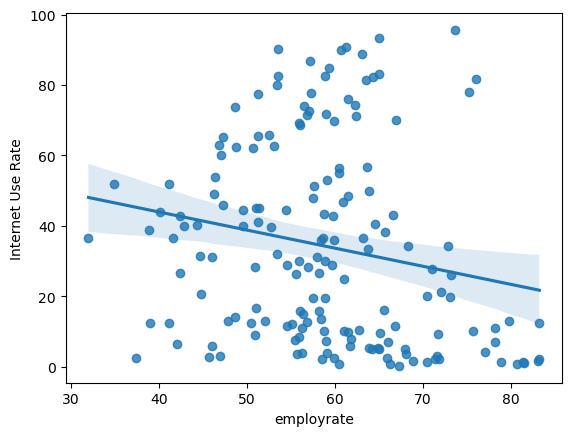

In [11]:
# Задание 3. 
# Постройте график зависимости 'employrate' и 'internetuserate' 
# с помощью функции plt_regression (ее мы определили выше)
plt_regression('employrate', 'internetuserate', df_clean, 'employrate', 'Internet Use Rate')

Какие выводы можно сделать из построенного графика?

##### Вычилим значение коэффициента корреляции для факторов 'employrate' и 'internetuserate'

В случае текущих данных нам можно применить корреляцию Пирсона. На это есть несколько причин:
- у нас есть точные наблюдаемые значения (не приближенные, с которыми помогает работать коэффициент корреляции Спирмена)
- корреляция Пирсона похзволяет получать более точные значения, так как работает с точными значениями

In [12]:
# для его вычисления вопользуемся встроенной функцией библиотеки scipy.stats
from scipy.stats import pearsonr

In [13]:
# Задание 4. Вычислим коэффициент корреляции для исследуемых факторов - employrate и internetuserate

# передаем в функцию две переменные - набор значений для первого фактора и для второго. 

print('Pearson correlation: ')
print(pearsonr(df_clean['employrate'], 
               df_clean['internetuserate']))

Pearson correlation: 
PearsonRResult(statistic=-0.19430856705848096, pvalue=0.011863147819071348)
